# L-shaped geometry

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from ngsolve import *
import matplotlib.pyplot as plt
import sys
import gc

sys.path.insert(1, "/Users/gpin/Repos/EVErrorEst/scripts")

from main_utils import *
from adapt_lshape import *
from error import *
from ngsolve.webgui import Draw
from IPython.display import display, HTML

## Geometry

In [2]:
def reset_mesh():
    return Mesh(make_l_shape().GenerateMesh(maxh=0.2))


mesh = reset_mesh()
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

# Adaptivity based on the landscape function

## Error estimator

In [3]:
def error_estimator_landscape(gf):
    """
    Compute the landscape error estimator.
    """
    h = specialcf.mesh_size
    n = specialcf.normal(gf.space.mesh.dim)
    xs = [x, y, z][: gf.space.mesh.dim]

    grad_gf = grad(gf)
    div_grad_gf = sum((grad_gf[i].Diff(xs[i]) for i in range(gf.space.mesh.dim)))

    integrand_1 = -div_grad_gf - 1.0
    integrand_2 = (grad_gf - grad_gf.Other()) * n

    eta_1 = Integrate(
        h**2 * InnerProduct(integrand_1, integrand_1) * dx,
        gf.space.mesh,
        element_wise=True,
    )
    eta_2 = Integrate(
        0.5 * h * InnerProduct(integrand_2, integrand_2) * dx(element_boundary=True),
        gf.space.mesh,
        element_wise=True,
    )

    eta = np.sqrt(eta_1.NumPy().real + eta_2.NumPy().real)
    etas = {
        "eta_1": eta_1.NumPy().real,
        "eta_2": eta_2.NumPy().real,
    }

    return eta, etas

## Assemble laplacian

In [4]:
# FES parameters
ORDER = 2
IS_COMPLEX = True

# Adaptivity parameters
MAX_ITER = 100
MAX_NDOFS = 300_000
THETA = 0.5

In [5]:
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

In [6]:
u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

In [7]:
iteration = 0
ndofs = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# --- Store values ---
df = pd.DataFrame(columns=["ndofs", "eta_l2", "eta_max", "eta_avg"])

# Main loop
while iteration < MAX_ITER and ndofs < MAX_NDOFS:
    # Update
    assemble(a, f)
    ndofs = fes.ndof
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # Estimate
    eta, _ = error_estimator_landscape(sol)
    # Mark
    max_eta = max(eta)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta > THETA * max_eta
    # Refine
    mesh.Refine()
    # --- Store values ---
    temp_df = pd.DataFrame(
        {
            "ndofs": ndofs * 1.0,
            "eta_l2": np.linalg.norm(eta, ord=2),
            "eta_max": np.max(eta),
            "eta_avg": np.mean(eta),
        },
        index=[0],
    )
    df = pd.concat([df, temp_df])

/var/folders/f7/10q8jl051xl_zh3qpm0x29100000gn/T/ipykernel_86542/4233022400.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df =  pd.concat([df,temp_df])


### Error estimators decay

<Axes: xlabel='ndofs'>

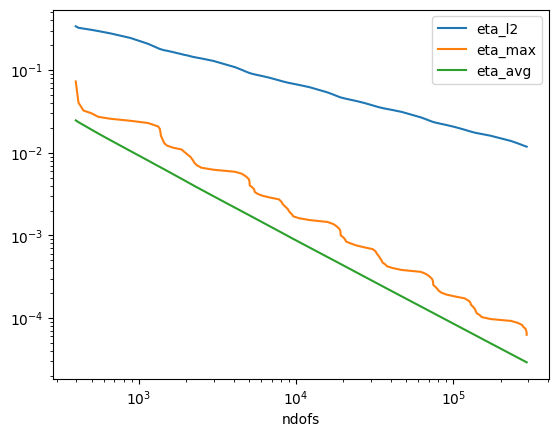

In [8]:
# df.drop(columns='ndofs')
df.plot(x="ndofs", loglog=True)

### Order of decay for error estimators

In [9]:
def get_order_convergence(ndofs, data):
    return -np.log(data[1:-1] / data[2:]) / np.log(ndofs[1:-1] / ndofs[2:])

In [10]:
order_l2 = get_order_convergence(df.ndofs, df.eta_l2)
order_max = get_order_convergence(df.ndofs, df.eta_max)
order_avg = get_order_convergence(df.ndofs, df.eta_avg)

order_df = pd.DataFrame(
    {
        "order_l2": order_l2,
        "order_max": order_max,
        "order_avg": order_avg,
    }
)

In [11]:
order_df

,order_l2,order_max,order_avg
0,0.299230,3.020801,1.084080
0,0.300142,0.663954,1.095271
0,0.345362,0.993714,1.087518
0,0.360724,0.301607,1.045511
0,0.432884,0.192602,1.031601
...,...,...,...
0,0.722747,2.963566,1.003892
0,0.699733,1.661106,1.000605
0,0.649448,5.247200,1.001970
0,0.595775,9.588867,1.011433


# Checking other eigenvalues in the loop

## Settings (cf. above)

In [12]:
REF_EV_1 = 9.6397238
REF_EV_5 = 31.912636
REF_EV_20 = 101.60529
REF_EV_50 = 250.78548
REF_32PI2 = 32 * np.pi**2

CENTER = {
    "ev1": REF_EV_1,
    "ev5": REF_EV_5,
    "ev20": REF_EV_20,
    "ev50": REF_EV_50,
    "32pi2": REF_32PI2,
}

In [38]:
# FES parameters
ORDER = 2
IS_COMPLEX = True

# Adaptivity parameters
MAX_ITER = 100
MAX_NDOFS = 200_000
THETA = 0.5

# FEAST parameters
NSPAN = 4
CHECKS = False
RADIUS = 0.5

feast_parameters = {
    "hermitian": False,
    "stop_tol": 1.0e-10,
    "cut_tol": 1.0e-10,
    "eta_tol": 1e-10,
    "nrestarts": 5,
    "niterations": 100,
}

# Reset spaces
mesh = reset_mesh()
fes = H1(mesh, order=ORDER, complex=IS_COMPLEX, dirichlet="boundary", autoupdate=True)

# Reset forms
u, v = fes.TnT()

a = BilinearForm(fes)
a += grad(u) * grad(v) * dx

m = BilinearForm(fes)
m += u * v * dx

f = LinearForm(fes)
f += 1.0 * v * dx

assemble(a, m, f)

## Adaptivity loop

In [39]:
iteration = 0
ndofs = 0
sol = GridFunction(fes, name="Landscape", autoupdate=True)

# --- Store values ---
df = pd.DataFrame(columns=["ndofs", "eta_l2", "eta_max", "eta_avg"])
evalues = {
    "ev1": [],
    "ev5": [],
    "ev20": [],
    "ev50": [],
    "32pi2": [],
}
evectors = {
    "ev1": [],
    "ev5": [],
    "ev20": [],
    "ev50": [],
    "32pi2": [],
}

# Main loop
while iteration < MAX_ITER and ndofs < MAX_NDOFS:
    # Update
    assemble(a, m, f)
    ndofs = fes.ndof
    iteration += 1
    # Solve
    sol.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
    # --- Init  call FEAST ---
    for name, center in CENTER.items():
        # Set clean eigenspace (required for adaptivity)
        right = NGvecs(fes, NSPAN)
        right.setrandom()
        left = NGvecs(fes, NSPAN)
        left.setrandom()

        # Set spectral projector
        projector = SpectralProjNG(
            fes,
            a.mat,
            m.mat,
            checks=CHECKS,
            radius=RADIUS,
            center=center,
            npts=NPTS,
            verbose=False,
        )
        # Call FEAST
        evalue, right, history, left = projector.feast(
            right, Yl=left, **feast_parameters
        )
        assert history[-1], "FEAST did not converge"
        # Save into list
        evalues[name].append(evalue)
        evectors[name].append(right.gridfun(name=name))
        # Clean up
        del right, left, projector, history, evalue
        gc.collect()
    # --- End  call  FEAST ---
    # Estimate
    eta, _ = error_estimator_landscape(sol)
    # Mark
    max_eta = max(eta)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta > THETA * max_eta
    # Refine
    mesh.Refine()
    # --- Store values ---
    temp_df = pd.DataFrame(
        {
            "ndofs": ndofs * 1.0,
            "eta_l2": np.linalg.norm(eta, ord=2),
            "eta_max": np.max(eta),
            "eta_avg": np.mean(eta),
        },
        index=[0],
    )
    df = pd.concat([df, temp_df])

/var/folders/f7/10q8jl051xl_zh3qpm0x29100000gn/T/ipykernel_86542/4062456132.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df =  pd.concat([df,temp_df])


### Landscape function

In [40]:
Draw(sol, mesh, name="Landscape")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Eigenvectors

In [41]:
Draw(evectors["ev1"][-1], mesh, name="ev1")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [42]:
Draw(evectors["ev5"][-1], mesh, name="ev5")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [43]:
Draw(evectors["ev20"][-1], mesh, name="ev20")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [44]:
Draw(evectors["ev50"][-1], mesh, name="ev50")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [45]:
Draw(evectors["32pi2"][-1], mesh, name="32pi2")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

### Eigenvalue plots

In [46]:
CENTER = {
    "ev1": REF_EV_1,
    "ev5": REF_EV_5,
    "ev20": REF_EV_20,
    "ev50": REF_EV_50,
    "32pi2": REF_32PI2,
}

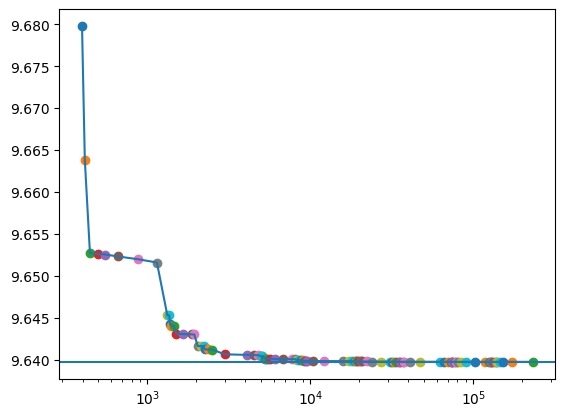

In [47]:
avg_ev1 = np.array([abs(np.mean(ev)) for ev in evalues["ev1"]])

fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev1"]):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(df.ndofs, avg_ev1)
plt.axhline(CENTER["ev1"])  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

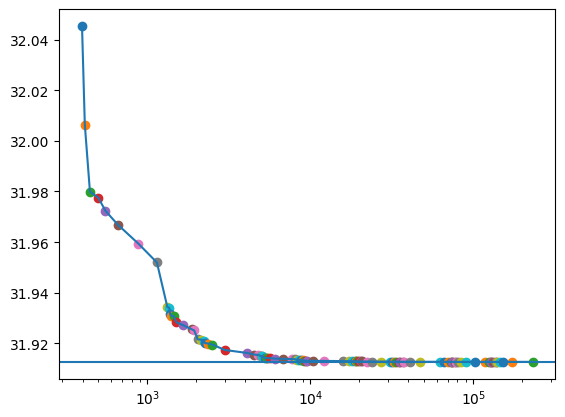

In [48]:
avg_ev5 = np.array([abs(np.mean(ev)) for ev in evalues["ev5"]])

fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev5"]):
    ax.scatter([ndof] * len(evs), evs.real)
ax.set_xscale("log")
ax.plot(df.ndofs, avg_ev5)
plt.axhline(CENTER["ev5"])  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

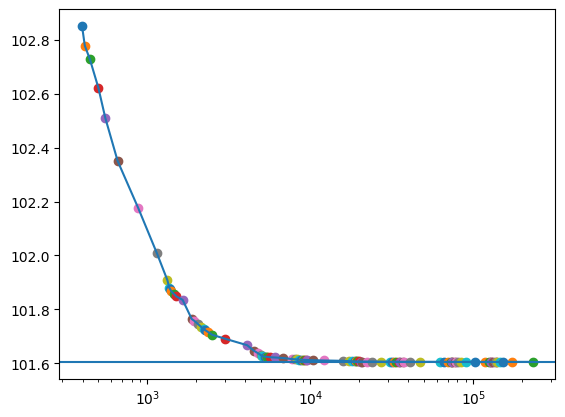

In [49]:
avg_ev20 = np.array([abs(np.mean(ev)) for ev in evalues["ev20"]])

fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev20"]):
    ax.scatter([ndof] * len(evs), evs.real)
ax.plot(df.ndofs, avg_ev20)
ax.set_xscale("log")
plt.axhline(CENTER["ev20"])  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

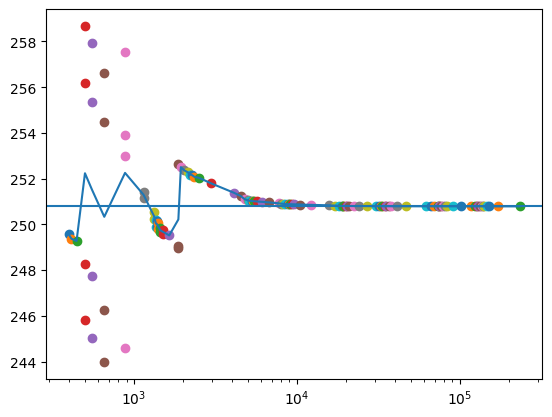

In [50]:
avg_ev50 = np.array([abs(np.mean(ev)) for ev in evalues["ev50"]])

fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev50"]):
    ax.scatter([ndof] * len(evs), evs.real)
ax.plot(df.ndofs, avg_ev50)
ax.set_xscale("log")
plt.axhline(CENTER["ev50"])  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

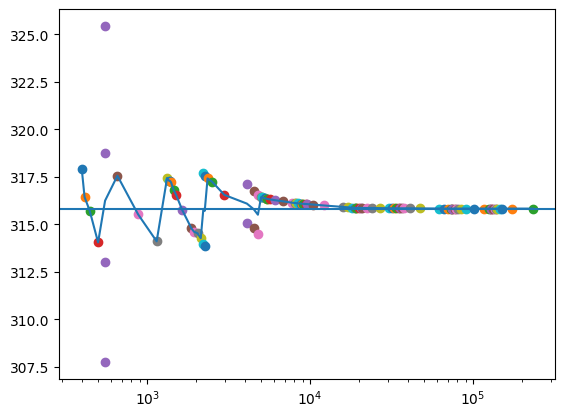

In [51]:
avg_ev32pi2 = np.array([abs(np.mean(ev)) for ev in evalues["32pi2"]])

fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["32pi2"]):
    ax.scatter([ndof] * len(evs), evs.real)
ax.plot(df.ndofs, avg_ev32pi2)
ax.set_xscale("log")
plt.axhline(CENTER["32pi2"])  # , xmin=df.ndofs[0], xmax=df.ndofs[-1])
plt.show()

### Errors estimators (cf. above)

<Axes: xlabel='ndofs'>

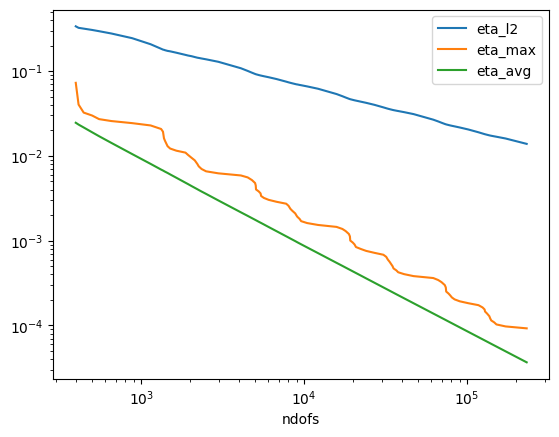

In [52]:
df.plot(x="ndofs", loglog=True)

### Errors and error orders

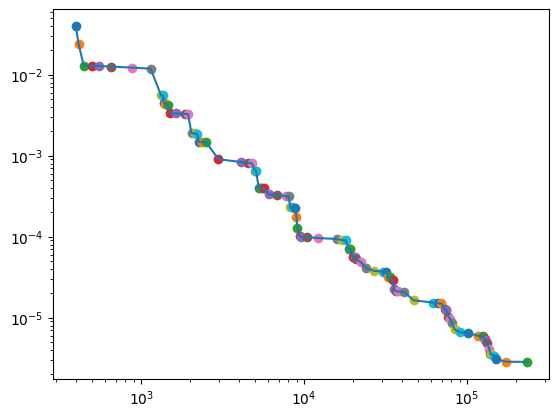

In [53]:
fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev1"]):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER["ev1"]))
ax.plot(df.ndofs, np.abs(avg_ev1 - CENTER["ev1"]))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

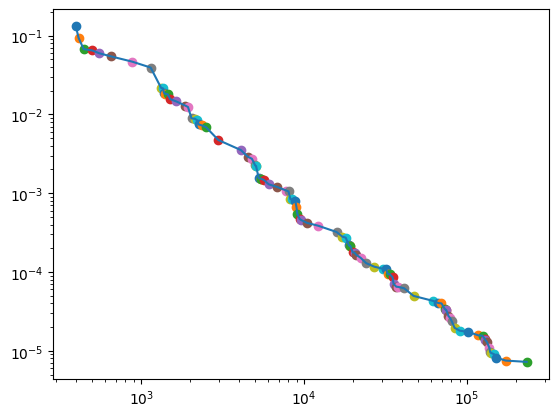

In [54]:
fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev5"]):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER["ev5"]))
ax.plot(df.ndofs, np.abs(avg_ev5 - CENTER["ev5"]))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

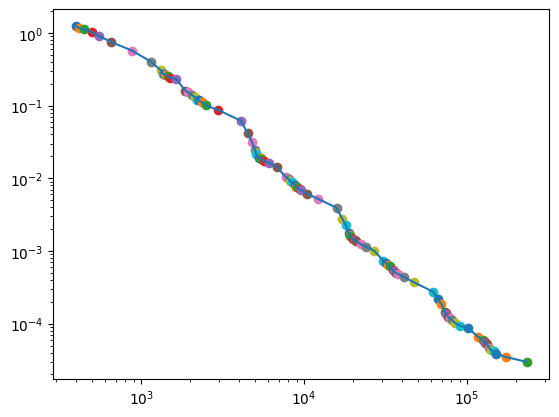

In [55]:
fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev20"]):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER["ev20"]))
ax.plot(df.ndofs, np.abs(avg_ev20 - CENTER["ev20"]))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

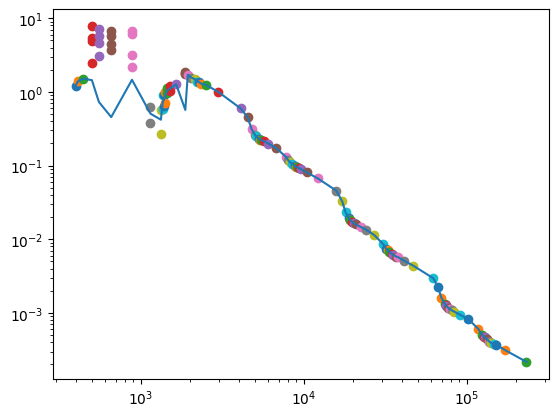

In [56]:
fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["ev50"]):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER["ev50"]))
ax.plot(df.ndofs, np.abs(avg_ev50 - CENTER["ev50"]))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

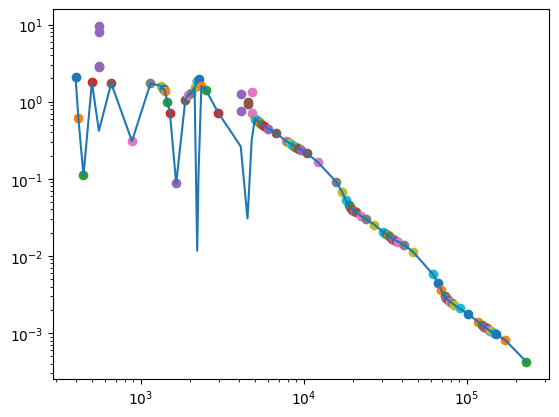

In [57]:
fig, ax = plt.subplots()
for ndof, evs in zip(df.ndofs, evalues["32pi2"]):
    ax.scatter([ndof] * len(evs), np.abs(evs - CENTER["32pi2"]))
ax.plot(df.ndofs, np.abs(avg_ev32pi2 - CENTER["32pi2"]))
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

### Strongness/correlation of the landscape function (Fourier coefficient)

In [58]:
fc_1 = Integrate(InnerProduct(CF(1.0), evectors["ev1"][-1]) * dx, mesh)
fc_1 /= (
    np.sqrt(np.real(Integrate(Norm(evectors["ev1"][-1]) ** 2 * dx, mesh)))
    * CENTER["ev1"]
)
print(f"Fourier coefficient: {fc_1}")

Fourier coefficient: (0.09994637849679992-0.0997668570342814j)


In [59]:
fc_5 = Integrate(InnerProduct(CF(1.0), evectors["ev5"][-1]) * dx, mesh)
fc_5 /= (
    np.sqrt(np.real(Integrate(Norm(evectors["ev5"][-1]) ** 2 * dx, mesh)))
    * CENTER["ev5"]
)
print(f"Fourier coefficient: {fc_5}")

Fourier coefficient: (0.009567146717573355-0.009735371808279205j)


In [60]:
fc_20 = Integrate(InnerProduct(CF(1.0), evectors["ev20"][-1]) * dx, mesh)
fc_20 /= (
    np.sqrt(np.real(Integrate(Norm(evectors["ev20"][-1]) ** 2 * dx, mesh)))
    * CENTER["ev20"]
)
print(f"Fourier coefficient: {fc_20}")

Fourier coefficient: (0.0011436062609372956-0.001127384751497171j)


In [61]:
fc_50 = Integrate(InnerProduct(CF(1.0), evectors["ev50"][-1]) * dx, mesh)
fc_50 /= (
    np.sqrt(np.real(Integrate(Norm(evectors["ev50"][-1]) ** 2 * dx, mesh)))
    * CENTER["ev50"]
)
print(f"Fourier coefficient: {fc_50}")

Fourier coefficient: (0.0005170977543694459-0.0005334968935243902j)


In [62]:
fc_32pi2 = Integrate(InnerProduct(CF(1.0), evectors["32pi2"][-1]) * dx, mesh)
fc_32pi2 /= (
    np.sqrt(np.real(Integrate(Norm(evectors["32pi2"][-1]) ** 2 * dx, mesh)))
    * CENTER["32pi2"]
)
print(f"Fourier coefficient: {fc_32pi2}")

Fourier coefficient: (1.2082842462058825e-07+4.2375567478669774e-07j)
